# Data preprocess
1 Import Necessary Libraries

2 Load the Data

3 Check for Missing Values

4 Data Augmentation (Optional)

5 Encode Labels

6 Feature Extraction Using a Pre-trained Model

7 Apply Clustering Algorithm

8 Outlier Detection and Removal

9 Split Data into Train, Validation, and Test Sets

10 Normalize the Images

11 Prepare the Data for the Model

1. Import libraries

In [30]:
import os
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.models import VGG16_Weights
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest





2. Load the data

In [31]:
data_df = pd.read_csv(r'..\..\data\raw\dataset_2\dogs.csv')
print(data_df.head())


              filepaths  labels data set
0  train/Afghan/001.jpg  Afghan    train
1  train/Afghan/002.jpg  Afghan    train
2  train/Afghan/003.jpg  Afghan    train
3  train/Afghan/004.jpg  Afghan    train
4  train/Afghan/005.jpg  Afghan    train


3. Check missing value

In [32]:
print(data_df.isnull().sum())


filepaths    0
labels       0
data set     0
dtype: int64


 4. Data Augmentation (Func to make the data various)

In [33]:

# 4. Data Augmentation (Optional)
# Define data augmentation and normalization transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(128),  # Randomly resize and crop the image
        transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
        transforms.ToTensor(),  # Convert image to PyTorch tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize image with mean and std
    ]),
    'valid': transforms.Compose([
        transforms.Resize(128),  # Resize the image
        transforms.CenterCrop(128),  # Center crop the image
        transforms.ToTensor(),  # Convert image to PyTorch tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize image with mean and std
    ]),
    'test': transforms.Compose([
        transforms.Resize(128),  # Resize the image
        transforms.CenterCrop(128),  # Center crop the image
        transforms.ToTensor(),  # Convert image to PyTorch tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize image with mean and std
    ]),
}

print(data_transforms)

{'train': Compose(
    RandomResizedCrop(size=(128, 128), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear), antialias=None)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'valid': Compose(
    Resize(size=128, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(128, 128))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'test': Compose(
    Resize(size=128, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(128, 128))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}


In [34]:
print(data_transforms)

{'train': Compose(
    RandomResizedCrop(size=(128, 128), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear), antialias=None)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'valid': Compose(
    Resize(size=128, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(128, 128))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'test': Compose(
    Resize(size=128, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(128, 128))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}


5. Encode Labels

In [35]:

# 5. Encode Labels
# Instantiate LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels
data_df['labels'] = label_encoder.fit_transform(data_df['labels'])

# Check the unique values in the 'labels' column to confirm encoding
print(data_df['labels'].unique())
print(data_df.head())

[ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70  3]
              filepaths  labels data set
0  train/Afghan/001.jpg       0    train
1  train/Afghan/002.jpg       0    train
2  train/Afghan/003.jpg       0    train
3  train/Afghan/004.jpg       0    train
4  train/Afghan/005.jpg       0    train


6. Feature Extraction Using a Pre-trained Model

In [36]:

# 6. Feature Extraction Using a Pre-trained Model
# Check if a GPU is available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda")


# Load the VGG16 model with the correct weights and move it to the GPU if available
vgg16_weights = models.VGG16_Weights.IMAGENET1K_V1
vgg16 = models.vgg16(weights=vgg16_weights).features.to(device)
vgg16.eval()  # Set the model to evaluation mode

# Define normalization transform using the mean and std of the ImageNet dataset
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


def extract_features(image_path):
    img = Image.open(image_path).convert('RGB')  # Open the image and convert to RGB
    img = transforms.Resize((128, 128))(img)  # Resize the image
    img = transforms.ToTensor()(img)  # Convert image to PyTorch tensor
    img = normalize(img)  # Normalize the image
    img = img.unsqueeze(0).to(device)  # Add batch dimension (for vg116 input) and move to GPU if available
    with torch.no_grad():  # No need to calculate gradients
        features = vgg16(img).flatten().cpu().numpy()  # Extract features, flatten the tensor, and move to CPU
    torch.cuda.empty_cache()  # Clear the cache
    return features


# Initialize an empty list to store the features
features_list = []

# Base directory where the images are stored
base_dir = r'..\..\data\raw\dataset_2'

# Iterate over each row in the DataFrame
for index, row in data_df.iterrows():
    image_path = os.path.join(base_dir, row['filepaths'])  # Construct the full image path
    features = extract_features(image_path)  # Extract features for the image
    features_list.append(features)  # Append the features to the list

# Add the features as a new column in the DataFrame
data_df['features'] = features_list

# Print the DataFrame with the new features column
print(data_df.head())

              filepaths  labels data set  \
0  train/Afghan/001.jpg       0    train   
1  train/Afghan/002.jpg       0    train   
2  train/Afghan/003.jpg       0    train   
3  train/Afghan/004.jpg       0    train   
4  train/Afghan/005.jpg       0    train   

                                            features  
0  [0.0, 0.0, 0.0, 0.0055029914, 0.0, 0.0, 0.9368...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 0.13881153, 0.0, 0.0, 0.0, 0.0, 0.0...  
3  [1.5880679, 0.3885551, 0.0, 0.0, 0.19158024, 0...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3948036,...  


In [37]:
# Save the corrected DataFrame if needed
data_df.to_csv(r'..\..\data\raw\dataset_2\dogs_corrected.csv', index=False)

7. Apply Clustering Algorithm

In [38]:

# 7. Apply Clustering Algorithm
# Prepare the feature matrix
X = np.array(data_df['features'].tolist())


#Use PCA when :
# - dataset has alot feature dimensions : 
# - reduce overfitting (The model can also learn 'noise_data') 
# Easy to vissualize with low dimension
# Find columns with contain multiples data https://www.youtube.com/watch?v=FgakZw6K1QQ&t=110s
# Ex: [1.1646723 0.        0.        ... 2.3116229 0.        1.3031149]

# Apply PCA for dimensionality reduction
pca = PCA(n_components=50) # Reduce to 50 dimension
X_pca = pca.fit_transform(X)

# Apply KMeans clustering
n_clusters = 10  # Number of clusters
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)  # Explicitly set n_init to suppress warning
data_df['cluster'] = kmeans.fit_predict(X_pca)

# Display the DataFrame with the new cluster column
print(data_df.head())

              filepaths  labels data set  \
0  train/Afghan/001.jpg       0    train   
1  train/Afghan/002.jpg       0    train   
2  train/Afghan/003.jpg       0    train   
3  train/Afghan/004.jpg       0    train   
4  train/Afghan/005.jpg       0    train   

                                            features  cluster  
0  [0.0, 0.0, 0.0, 0.0055029914, 0.0, 0.0, 0.9368...        3  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...        3  
2  [0.0, 0.0, 0.13881153, 0.0, 0.0, 0.0, 0.0, 0.0...        3  
3  [1.5880679, 0.3885551, 0.0, 0.0, 0.19158024, 0...        3  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3948036,...        3  


In [39]:
print(X) # Feartures của từng ảnh, có 50 chiều

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.13881153 ... 0.         0.         0.547051  ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


8. Outlier Detection and Removal

- Có thể dùng IQR để tìm Q1  Q2, rồi tìm ra outlier: Nhưng outliers chỉ hoạt động với feartures ít chiều
- Isolation Forest: dựa trên (tree-based) được sử dụng để phát hiện các điểm bất thường (outliers) trong tập dữ liệu. 

Isolation: Thuật toán này hoạt động dựa trên ý tưởng rằng các outliers dễ bị cô lập hơn so với các điểm dữ liệu thông thường. Nó xây dựng nhiều cây quyết định (decision trees) ngẫu nhiên và sử dụng các đường chia ngẫu nhiên để cô lập các điểm dữ liệu.

Anomaly Score: Các điểm dữ liệu bị cô lập nhanh hơn (tức là ở các mức cao hơn trong cây) sẽ có điểm bất thường cao hơn. Điểm bất thường này được sử dụng để xác định liệu một điểm dữ liệu có phải là outlier hay không.

Contamination: Tham số contamination cho biết tỷ lệ dự kiến của outliers trong tập dữ liệu.
contamination=0.05 :  khoảng 5% dữ liệu dự kiến là outliers.

              filepaths  labels data set  \
0  train/Afghan/001.jpg       0    train   
1  train/Afghan/002.jpg       0    train   
2  train/Afghan/003.jpg       0    train   
3  train/Afghan/004.jpg       0    train   
4  train/Afghan/005.jpg       0    train   

                                            features  cluster  outlier  \
0  [0.0, 0.0, 0.0, 0.0055029914, 0.0, 0.0, 0.9368...        3        1   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...        3        1   
2  [0.0, 0.0, 0.13881153, 0.0, 0.0, 0.0, 0.0, 0.0...        3        1   
3  [1.5880679, 0.3885551, 0.0, 0.0, 0.19158024, 0...        3        1   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3948036,...        3        1   

    feature1   feature2  
0   4.559377  -6.067694  
1  -6.435074   4.959893  
2  11.736947 -22.581755  
3  12.708912  -6.565281  
4  20.132664 -32.515427  


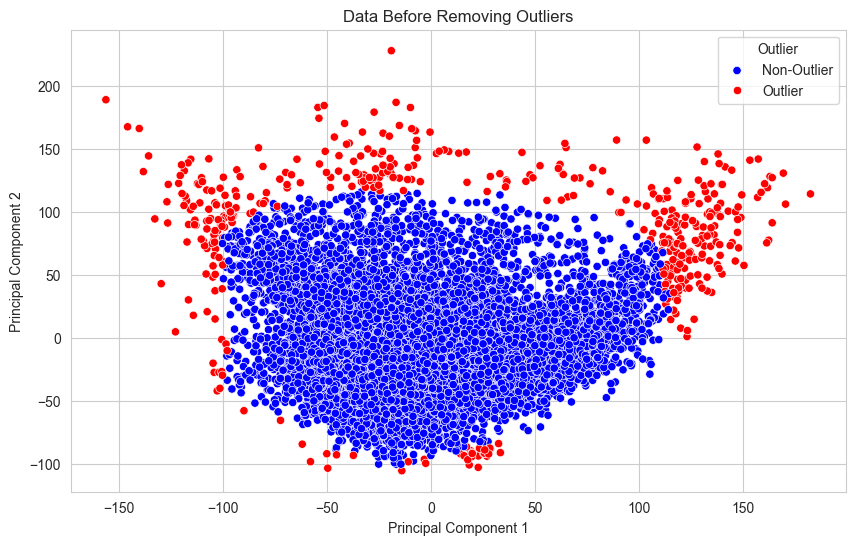

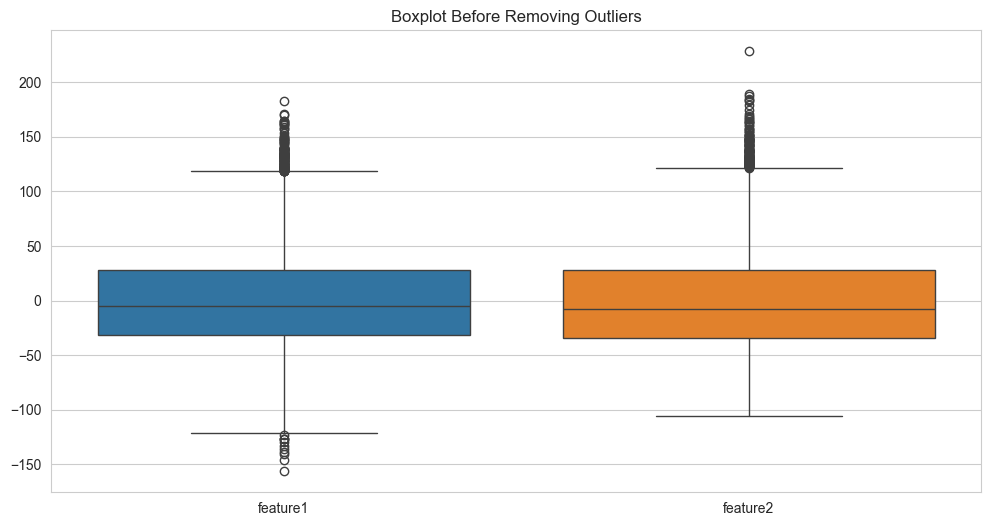

In [65]:

# 8. Outlier Detection and Removal
# Apply Isolation Forest for outlier detection
iso_forest = IsolationForest(contamination=0.05, random_state=42)  # 5% contamination
outliers = iso_forest.fit_predict(X_pca) # Detect outliers
data_df['outlier'] = outliers #Outliers to be new column in dataset
# Thêm cột 'outlier' vào DataFrame


# Kiểm tra DataFrame để đảm bảo cột 'outlier' đã được thêm đúng cách
print(data_df.head())

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=outliers, palette={1: 'blue', -1: 'red'})
plt.title('Data Before Removing Outliers')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Outlier', loc='upper right', labels=['Non-Outlier', 'Outlier'])
plt.show()

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
data_df['feature1'] = X_pca[:, 0]
data_df['feature2'] = X_pca[:, 1]


# Boxplot before remove outlier
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_df[['feature1', 'feature2']])
plt.title('Boxplot Before Removing Outliers')
plt.show()



In [66]:
# Check the value of Outliers
print(data_df['outlier'].value_counts())

outlier
 1    8878
-1     468
Name: count, dtype: int64


In [67]:
# Keep data not outlier(outlier label = 1)
data_df_no_outliers = data_df[data_df['outlier'] == 1].drop(columns=['outlier'])

# Hiển thị DataFrame sau khi loại bỏ outliers
print(data_df_no_outliers.head())


              filepaths  labels data set  \
0  train/Afghan/001.jpg       0    train   
1  train/Afghan/002.jpg       0    train   
2  train/Afghan/003.jpg       0    train   
3  train/Afghan/004.jpg       0    train   
4  train/Afghan/005.jpg       0    train   

                                            features  cluster   feature1  \
0  [0.0, 0.0, 0.0, 0.0055029914, 0.0, 0.0, 0.9368...        3   4.560023   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...        3  -6.433100   
2  [0.0, 0.0, 0.13881153, 0.0, 0.0, 0.0, 0.0, 0.0...        3  11.737623   
3  [1.5880679, 0.3885551, 0.0, 0.0, 0.19158024, 0...        3  12.709305   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3948036,...        3  20.131708   

    feature2  
0  -6.065106  
1   4.963177  
2 -22.579590  
3  -6.564245  
4 -32.516518  


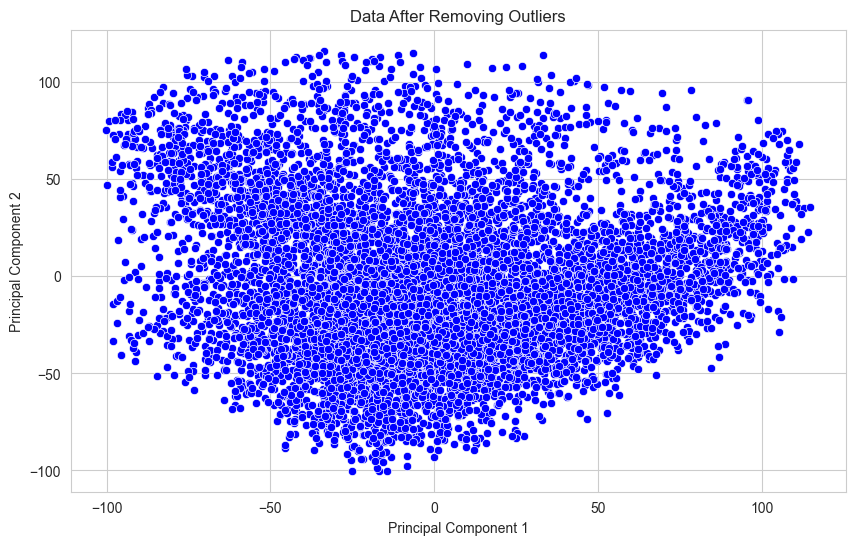

In [68]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[data_df['outlier'] == 1, 0], y=X_pca[data_df['outlier'] == 1, 1], color='blue')
plt.title('Data After Removing Outliers')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


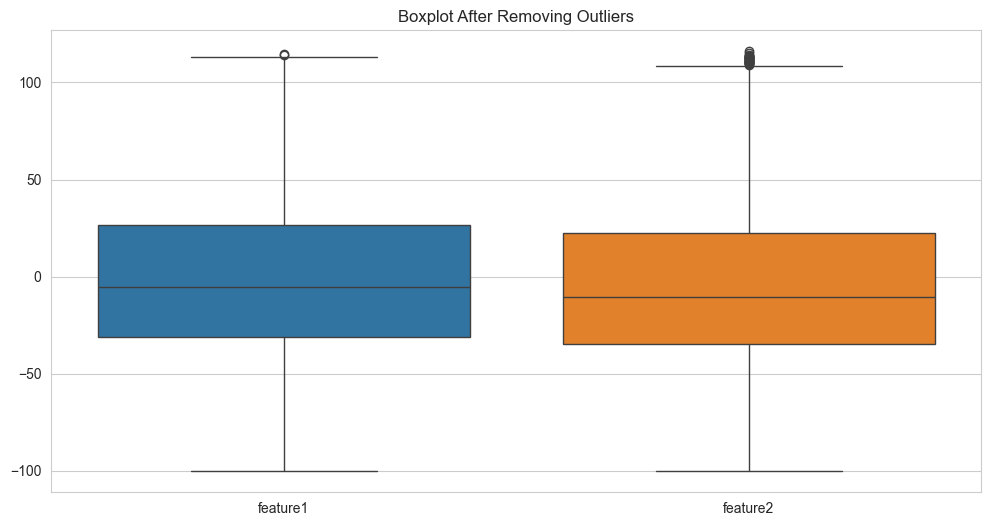

In [69]:
# Boxplot sau khi loại bỏ outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_df_no_outliers[['feature1', 'feature2']])
plt.title('Boxplot After Removing Outliers')
plt.show()

9. Split Data into Train, Validation, and Test Sets

In [71]:

# 9. Split Data into Train, Validation, and Test Sets
# Ensure the dataset has a 'data set' column specifying the split
if 'data set' in data_df.columns:
    # Split the data into training, validation, and test sets
    train_df = data_df[data_df['data set'] == 'train']
    valid_df = data_df[data_df['data set'] == 'valid']
    test_df = data_df[data_df['data set'] == 'test']

    # Remove the 'data set' column as it's no longer needed
    train_df = train_df.drop(columns=['data set'])
    valid_df = valid_df.drop(columns=['data set'])
    test_df = test_df.drop(columns=['data set'])
else:
    print("Warning: The 'data set' column is missing from the DataFrame.")

# Display the DataFrame after splitting
print(train_df.head())
print(valid_df.head())
print(test_df.head())


              filepaths  labels  \
0  train/Afghan/001.jpg       0   
1  train/Afghan/002.jpg       0   
2  train/Afghan/003.jpg       0   
3  train/Afghan/004.jpg       0   
4  train/Afghan/005.jpg       0   

                                            features  cluster  outlier  \
0  [0.0, 0.0, 0.0, 0.0055029914, 0.0, 0.0, 0.9368...        3        1   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...        3        1   
2  [0.0, 0.0, 0.13881153, 0.0, 0.0, 0.0, 0.0, 0.0...        3        1   
3  [1.5880679, 0.3885551, 0.0, 0.0, 0.19158024, 0...        3        1   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3948036,...        3        1   

    feature1   feature2  
0   4.559304  -6.066920  
1  -6.437088   4.956140  
2  11.736710 -22.584585  
3  12.708435  -6.565771  
4  20.130095 -32.520756  
                filepaths  labels  \
8646  valid/Afghan/01.jpg       0   
8647  valid/Afghan/02.jpg       0   
8648  valid/Afghan/03.jpg       0   
8649  valid/Afghan/04.jpg       0   
865

10. Normalize the Images
- Normalization was already handled during feature extraction step 6

# Classification
    11.Prepare the Data for the Model

In [72]:

# 11. Prepare the Data for the Model
class DogDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Construct the full image path
        img_path = os.path.join(base_dir, self.dataframe.iloc[idx]['filepaths'])

        # Open the image and convert to RGB
        image = Image.open(img_path).convert('RGB')

        # Get the label and convert it to a tensor
        label = self.dataframe.iloc[idx]['labels']

        # Ensure the label is an integer (not a string)
        if isinstance(label, str):
            label = int(label)

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)  # Ensure the label is a tensor with long type


# Define data augmentation and normalization transformations for training and validation
# We already defined this in step 4
# Reuse the data augmentation and normalization transformations defined in step 4
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(128),  # Randomly resize and crop the image
        transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
        transforms.ToTensor(),  # Convert image to PyTorch tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize image with mean and std
    ]),
    'valid': transforms.Compose([
        transforms.Resize(128),  # Resize the image
        transforms.CenterCrop(128),  # Center crop the image
        transforms.ToTensor(),  # Convert image to PyTorch tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize image with mean and std
    ]),
    'test': transforms.Compose([
        transforms.Resize(128),  # Resize the image
        transforms.CenterCrop(128),  # Center crop the image
        transforms.ToTensor(),  # Convert image to PyTorch tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize image with mean and std
    ]),
}

# Create datasets and dataloaders for train, validation, and test sets
train_dataset = DogDataset(train_df, transform=data_transforms['train'])
valid_dataset = DogDataset(valid_df, transform=data_transforms['valid'])
test_dataset = DogDataset(test_df, transform=data_transforms['test'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


12. Define and Train the PyTorch Model

In [74]:

# 12. Define and Train the PyTorch Model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # First convolutional layer
            nn.ReLU(),  # Activation function
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Second convolutional layer
            nn.ReLU(),  # Activation function
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Third convolutional layer
            nn.ReLU(),  # Activation function
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),  # Dropout layer
            nn.Linear(128 * 16 * 16, 512),  # Fully connected layer
            nn.ReLU(),  # Activation function
            nn.Dropout(0.5),  # Dropout layer
            nn.Linear(512, num_classes),  # Output layer
        )

    def forward(self, x):
        x = self.features(x)  # Extract features
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)  # Classify
        return x


num_classes = len(label_encoder.classes_)
model = SimpleCNN(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
import torch.optim.lr_scheduler as lr_scheduler

# Define the scheduler and early stopping parameters
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
early_stopping_patience = 10
early_stopping_counter = 0
best_val_loss = float('inf')

In [16]:

# Train the model

# Initialize lists to store losses
train_losses = []
val_losses = []

# Training loop
num_epochs = 300
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move to device
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        running_loss += loss.item() * images.size(0)  # Accumulate loss

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

    # Validation step
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)  # Move to device
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)

    val_loss = val_running_loss / len(valid_loader.dataset)
    val_losses.append(val_loss)
    print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss:.4f}')

    # Scheduler step
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

Epoch 1/300, Training Loss: 4.0611
Epoch 1/300, Validation Loss: 3.8869
Epoch 2/300, Training Loss: 3.8569
Epoch 2/300, Validation Loss: 3.7311
Epoch 3/300, Training Loss: 3.7570
Epoch 3/300, Validation Loss: 3.5797
Epoch 4/300, Training Loss: 3.6427
Epoch 4/300, Validation Loss: 3.5395
Epoch 5/300, Training Loss: 3.5436
Epoch 5/300, Validation Loss: 3.3910
Epoch 6/300, Training Loss: 3.4376
Epoch 6/300, Validation Loss: 3.2210
Epoch 7/300, Training Loss: 3.3591
Epoch 7/300, Validation Loss: 3.1713
Epoch 8/300, Training Loss: 3.3108
Epoch 8/300, Validation Loss: 3.1270
Epoch 9/300, Training Loss: 3.2433
Epoch 9/300, Validation Loss: 2.9583
Epoch 10/300, Training Loss: 3.2022
Epoch 10/300, Validation Loss: 2.8536
Epoch 11/300, Training Loss: 3.1541
Epoch 11/300, Validation Loss: 2.9290
Epoch 12/300, Training Loss: 3.1236
Epoch 12/300, Validation Loss: 2.8415
Epoch 13/300, Training Loss: 3.0829
Epoch 13/300, Validation Loss: 2.7605
Epoch 14/300, Training Loss: 3.0579
Epoch 14/300, Valida

In [22]:
# Load the best model
model.load_state_dict(torch.load('best_model.pt'))




<All keys matched successfully>

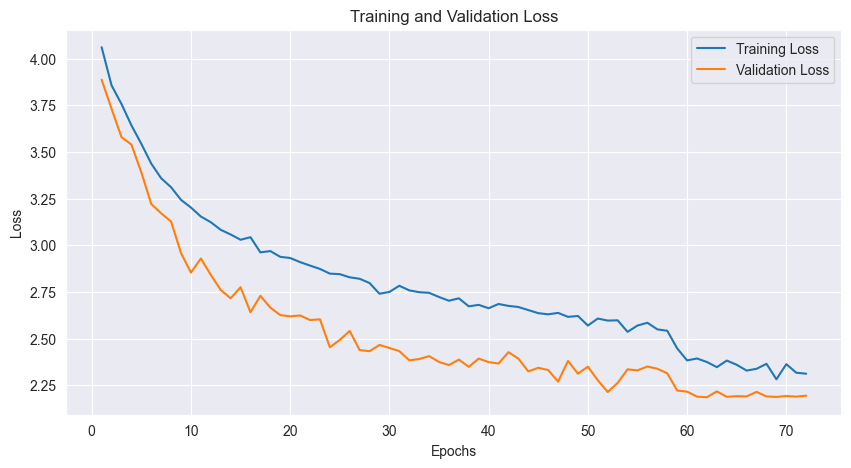

In [23]:
# Plot Training and Validation loss/
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Accuracy: 0.5084
Precision: 0.5329
Recall: 0.5084
F1 Score: 0.4917
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.47      0.70      0.56        10
           2       0.60      0.60      0.60        10
           4       0.83      0.50      0.62        10
           5       0.78      0.78      0.78         9
           6       0.42      1.00      0.59         5
           7       0.27      0.38      0.32         8
           8       0.50      0.60      0.55        10
           9       0.75      0.67      0.71         9
          10       0.75      1.00      0.86         9
          11       0.50      0.80      0.62        10
          12       0.50      0.75      0.60         4
          13       0.50      0.60      0.55        10
          14       0.20      0.10      0.13        10
          15       0.78      0.70      0.74        10
          16       0.50      0.10      0.17        10
          17  

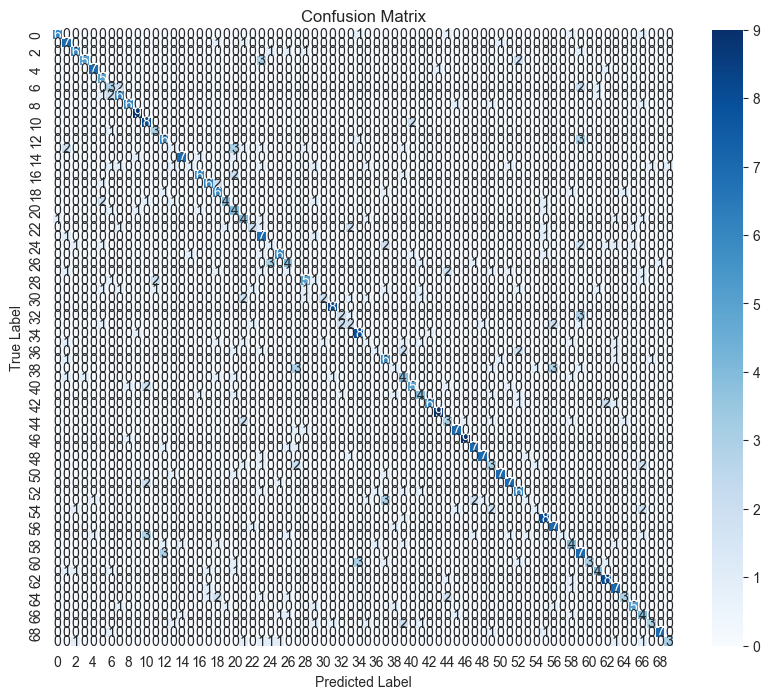

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

# Initialize lists to store metrics
all_labels = []
all_preds = []

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move to device
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
report = classification_report(all_labels, all_preds)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(report)

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

